<a href="https://colab.research.google.com/github/ownit4137/TIL/blob/main/DL%20from%20Scratch/2/210127_Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/'Colab Notebooks'/

Mounted at /content/gdrive/
/content/gdrive/MyDrive/Colab Notebooks


# 추론 기반 기법

- 통계 기반 기법에서는 주변 단어의 빈도를 기초로 단어를 표현함, 말뭉치가 커질수록 계산하는 비용이 매우 커짐
- 추론 기반 기법은 주변 맥락이 주어졌을 때 target을 추론하는 것
- 추론 문제를 신경망으로 학습시키는 것을 Word2vec이라 함
- Word2vec 모델에는 CBOW(Continuous Bag of Words)와 Skip-Gram 두 가지가 있음

## CBOW

![](https://wikidocs.net/images/page/22660/word2vec_renew_4.PNG)

https://wikidocs.net/22660

### 입력층(input, )

- 단어의 ID를 원핫으로 표현하여 입력층의 뉴런 수를 고정시킴
- 단어의 ID에 해당하는 뉴런 한개에서만 1이 입력됨
- 맥락에 포함시킬 단어가 많아지면 은닉층도 많아짐(window가 n이면 입력층이 2n개 만들어짐)

### W_in(input, hidden)

- 입력층과 은닉층 사이의 가중치
- 입력이 들어오면 input개의 뉴런 중 하나만 1이기 때문에 입력에 가중치를 곱하면 1인 뉴런에 곱해지는 하나의 행벡터가 추출됨 -> **단어의 분산 표현**
- 여러 입력층이 하나의 W_in을 공유함

### 은닉층(hidden, )

- 입력에 W_in을 곱한 결과를 저장하는 뉴런
- 입력층이 여러 개일때는 전체를 평균한 값을 사용
- 은닉층의 뉴런이 입력층보다 작음, **단어 예측에 필요한 정보를 간결하게 담을 수 있음**
- 입력을 은닉층으로 변환하는 과정을 인코딩, 은닉층을 우리가 알 수 있게 변환하는 과정을 디코딩이라 함

### W_out(hidden, input)

- 은닉층을 디코딩하는 가중치

### 출력층(input, )

- 은닉층에 W_out이 곱해져 각각의 뉴런이 단어별 출현 점수를 가지는 층
- 주로 출력층에 소프트맥스 함수를 통과시켜 나온 출현 확률을 사용함

In [10]:
import numpy as np
from common.util2 import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, wti, itw = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1) # 모든 contexts와 target을 반환
print("contexts, target shape :", contexts.shape, target.shape)

vocab_size = len(wti)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print("contexts, target shape(ont-hot) :", contexts.shape, target.shape)

contexts, target shape : (6, 2) (6,)
contexts, target shape(ont-hot) : (6, 2, 7) (6, 7)


In [38]:
from common.layers2 import MatMul, SoftmaxWithLoss  
# affine계층, Softmax-CEE 계층

class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # distributional representation
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

### forward

- affine연산값 = layer.forward(입력)
- 윈도우의 크기가 i이면 맥락에 포함되는 단어(contexts row의 갯수)가 2i개
- 한 맥락 안에서 단어 2i개에 따른 target을 모두 학습해 주어야 함, 입력층의 개수 2i개
- k번째 입력층에서 맥락의 k번째 단어(context의 k번째 row)를 학습
```  
context[:, 0] = context[:, 0, :], context[...][0][...]
depth(axis 2), row(axis 0), column(axis 1) 순으로 indexing
```

### backward

- 역전파 값 = layer.backward(이전 역전파 값)
- `+`의 역전파는 기울기를 그대로 통과시킴
- `*`의 역전파는 순전파 시의 입력을 서로 바꿔 곱합



In [ ]:
from common.trainer2 import Trainer
from common.optimizer2 import Adam

cbow = SimpleCBOW(vocab_size, hidden_size=5)
optimizer = Adam()
trainer = Trainer(cbow, optimizer)
trainer.fit(contexts, target, max_epoch=1000, batch_size=3)

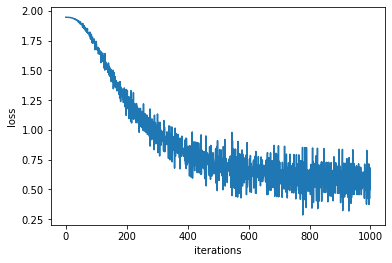

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(trainer.loss_list)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [45]:
dist_rep = cbow.word_vecs # distributional representation

for word_id, word in itw.items():
  print(word, dist_rep[word_id])

you [ 1.1009845 -1.1687964 -1.1375549 -1.2455428 -1.1252223]
say [-1.1991144   1.2497904   1.242143    0.08057171  0.5530844 ]
goodbye [ 0.8885245  -0.76481366 -0.7901251  -0.68070847 -0.7762243 ]
and [-1.0464666  1.057946   1.0525875  1.5976113  1.614526 ]
i [ 0.8809924  -0.75565386 -0.7620977  -0.67811626 -0.7734172 ]
hello [ 1.0959461 -1.1697292 -1.1548245 -1.2661765 -1.1295903]
. [-1.0778775  1.0894455  1.100113  -1.461588  -1.6160035]
